In [128]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import statistics

training data

In [129]:
# import data
df = pd.read_csv("data/test_dataset_no_missing_2.csv")
data = df.to_numpy()

In [130]:
(l, w) = data.shape
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0: 
            x_train[i, d*2] = p # 0 score
            x_train[i, d*2+1] = p # missing indicator
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score
x_train

array([[0.78208023, 0.21791977, 0.3816844 , 0.6183156 ],
       [0.39358905, 0.60641095, 0.31200055, 0.68799945],
       [0.0572248 , 0.9427752 , 0.78475412, 0.21524588],
       ...,
       [0.25542948, 0.74457052, 0.88261002, 0.11738998],
       [0.6164064 , 0.3835936 , 0.15777525, 0.84222475],
       [0.89770934, 0.10229066, 0.6429232 , 0.3570768 ]])

Autoencoder model

In [131]:
(l, w)

(500, 2)

In [132]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(2 * 2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 2 * 2),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [133]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [134]:
epochs = 20
outputs = []
losses = []
epoch_loss = []
for epoch in range(epochs):
    for session in x_train:
       
      session = session.reshape(-1, 2 * 2)
      session_t = torch.from_numpy(session)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
       
      # Output of Autoencoder
      reconstructed = model(session_t)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, session_t)
       
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
       
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())
    losses.append(statistics.mean(epoch_loss))
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

Epoch [1/20], Loss: 0.0516
Epoch [1/20], Loss: 0.0438
Epoch [1/20], Loss: 0.2921
Epoch [1/20], Loss: 0.1264
Epoch [1/20], Loss: 0.1115
Epoch [1/20], Loss: 0.2189
Epoch [1/20], Loss: 0.1306
Epoch [1/20], Loss: 0.0801
Epoch [1/20], Loss: 0.0563
Epoch [1/20], Loss: 0.0887
Epoch [1/20], Loss: 0.0002
Epoch [1/20], Loss: 0.1181
Epoch [1/20], Loss: 0.1284
Epoch [1/20], Loss: 0.0801
Epoch [1/20], Loss: 0.1727
Epoch [1/20], Loss: 0.0029
Epoch [1/20], Loss: 0.0881
Epoch [1/20], Loss: 0.0848
Epoch [1/20], Loss: 0.0084
Epoch [1/20], Loss: 0.0880
Epoch [1/20], Loss: 0.0173
Epoch [1/20], Loss: 0.1521
Epoch [1/20], Loss: 0.0696
Epoch [1/20], Loss: 0.0031
Epoch [1/20], Loss: 0.0113
Epoch [1/20], Loss: 0.0764
Epoch [1/20], Loss: 0.0226
Epoch [1/20], Loss: 0.0554
Epoch [1/20], Loss: 0.0325
Epoch [1/20], Loss: 0.2842
Epoch [1/20], Loss: 0.0187
Epoch [1/20], Loss: 0.1503
Epoch [1/20], Loss: 0.0506
Epoch [1/20], Loss: 0.2442
Epoch [1/20], Loss: 0.0858
Epoch [1/20], Loss: 0.0542
Epoch [1/20], Loss: 0.0407
E

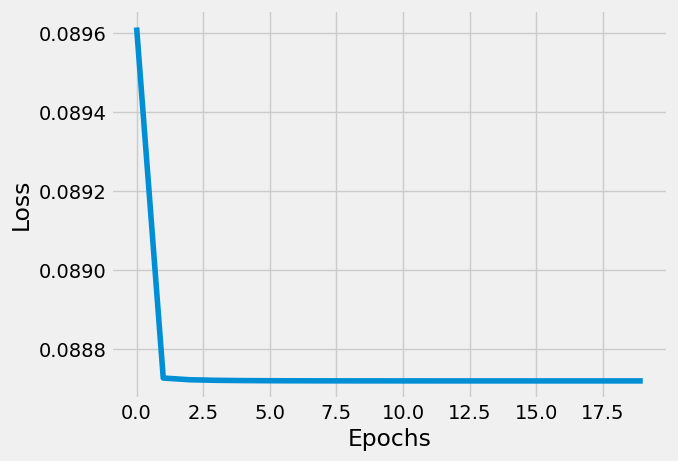

In [135]:
 # Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting
with torch.no_grad():
   plt.plot(losses[-200:])